# STA663 Final Report: Implementation and Optimization of Sinkhorn Algorithm

### Authors: Congwei Yang, Yijia Zhang, Haoliang Zheng

Github link: https://github.com/congwei-yang/663-Final-Project

# Installation

Use the following command in the terminal to install the package: 

`pip install --index-url https://test.pypi.org/simple/ sinkhorn_663`

Note that the package requires the up-to-date pybind11(2.6.2). Please install or update the pybind11 before installing the sinkhorn package. 

To import all the modules and functions, use the following code: 

`from sinkhorn_663 import sinkhorn, log_domain_sinkhorn, sinkhorn_numba, sinkhorn_numba_parallel`

`from sinkhorn_663 import sample_to_prob_vec, sample_to_prob_vec_nD`

`from sinkhorn_663.image import cost_mat, flatten, remove_zeros`

`from skh_cpp import sinkhorn_cpp`

For detailed documentation of functions, see the github repo above. 

# Abstract

This paper describes the implementations of the Sinkhorn algorithm [1] proposed by M. Cuturi in 2013. The algorithm provided an efficient approximation to the optimal transport (OT) distance. We built the sinkhorn implementation package `sinkhorn_663` and incorporated numba and c++ to optimize the Sinkhorn function. We also provided a few additional module for the user to conveniently convert random samples or images into empirical measures for Sinkhorn computation. Furthermore, we conducted experiments and tests to explore the properties of Sinkhorn algorithm. Primarily, we tested Sinkhorn algorithm for image testing and compared the Sinkhorn algorithm with the classical linear programming method proposed in [2]. Moreover, we addressed the numerical instability issue of Sinkhorn and compared it with the log-domain sinkhorn proposed in [5] as a pre-existed solution of the issue. Finally, we explored the trend of iteration number required in Sinkhorn algorithm with respect to the data size and regularization parameter $\lambda$, and concluded that the a large regularization parameter $\lambda$ will cause the algorithm requires a much larger iteration number. Overall, the Sinkhorn algorithm provides good approximation to the optimal transport distance while maintains relatively low computational cost. However, it is not perfect and has its own disadvantages. Thus, when solving actual problems, we should choose the most appropriate method based on the scenario to maintain sufficient accuracy and efficiency. 

## 1. Introduction

The optimal transport distance has crucial applications in the field of data anslysis and machine learning. Theoretically, optimal transport distance is a metric and can quantify the distance between probability measures with specified cost function. However, despite its potential applications and favorable properties, optimal transport is generally infeasiable in most probelms because of its high computational cost and the curse of dimensionality. In 2013, The Sinkhorn algorithm [1] was proposed by Marco Cuturi. It encorporates entropy regularization to reduce the computational burden, thus provided a much more efficient alternative of the original optimal transport distance. However, the entropy regularization also introduced bias to the framework, causing the Sinkhorn evaluated results to be strictly larger than the exact optimal transport distance. 

In this project, we will build a python package to compute the Sinkhorn distance. Moreover, the package provides functions that can convert random samples from probability measures into corresponding format for the computation of 1-Wasserstein distance, which is a special case of optimal transport distance. 
### 1.1 Theoretical Background and Algorithm Description

Before introducing the algorithm, we need to present definitions of the optimal transport problem and Wasserstein distance. 

*Definition 1*: (The Monge-Kantorovich Optimal Transport Problem) Denote the Borel probability measure of $\mathbb{R}^d$ as $\mathcal{P}(\mathbb{R}^d)$. Given a cost function $c(x, y)$, the optimal transport problem between probability measures $P, Q \in \mathcal{P}(\mathbb{R}^d)$ is defined as

\begin{equation}
d(P, Q) := \min_{\pi \in \Gamma(P, Q)}\int_{\mathbb{R}^d \times \mathbb{R}^d}{c(x, y) d\pi(x, y)}
\end{equation}

where $\pi$ is the coupling of $P$ and $Q$, (i.e. $(x, y) \sim \pi \to x\sim P, y\sim Q$). 

We can define the $p$-Wasserstein distance from a special case of optimal transport with $c(x, y) = \lVert X - Y \rVert^p$

*Definition 2*: From [3], with $p \in \mathbb{N}^+$ and probability measures $P, Q \in \mathcal{P}(\mathbb{R}^d)$ with finite $p$-th moment, the $p$-th Wasserstein Distance is defined as

\begin{equation}
W_p(P, Q) := \bigg(\inf_{\pi \in \Gamma(P, Q)} \int_{\mathbb{R}^d \times \mathbb{R}^d} \lVert X - Y \rVert^p d\pi\bigg)^{1/p}
\end{equation}

Since it is generally infeasible to directly evaluate probability measures, we need to approximate them using empirical measures. Thus, we need to further specify the optimal transport problem for empirical measures. 

*Definition 3*: From [1], let $r, c \in \{x \in \mathbb{R}^d_+, x^T\mathbf{1}_d = 1\}$ be empirical probability measures. We can define
\begin{equation}
    U(r, c) := \{ P \in \mathbb{R}^{d \times d}_+: P\mathbf{1}_d = r, P^T\mathbf{1}_d = c\}
\end{equation}
Then, the optimal transport distance between $r$ and $c$ given a cost matrix $M$ is defined as

\begin{equation}
    d_M(r, c) := \min_{P \in U(r, c)}\langle P, M\rangle
\end{equation}

The cost matrix $M$ is a metric matrix. In other word, $M$ belongs to the cone of distance matrices: 

\begin{equation}
    \{M \in \mathbb{R}^{d \times d}_+: \forall i, j \leq d, m_{ij} = 0 \leftrightarrow i = j, \forall i, j, k \leq d, m_{ij} \leq m_{ik} + m_{kj} \}
\end{equation}

With the definition of optimal transport problem for empirical measures, we can proceed to state the definition of Sinkhorn distance. 

*Definition 4*: From [1], denote the entropy of $r, c, P$ to be $h(r), h(c), h(P)$ respectively, then we can introduce the convex set

\begin{equation}
    U_\alpha(r, c) = \{P \in U(r, c) \mid h(P) \geq h(r) + h(c) - \alpha\}
\end{equation}

Then, we can define the Sinkhorn distance by

\begin{equation}
    d_{M, \alpha}(r, c) := \min_{P \in U_\alpha(r, c)}\langle P, M\rangle
\end{equation}

In practice, we will consider a Lagrange multiplier for the entropy constraint of the Sinkhorn distance [1]. For $\lambda > 0$, 

\begin{equation}
    d_M^{\lambda}(r, c) := \langle P^\lambda, M \rangle
\end{equation}

where $P^{\lambda} = argmin_{P \in U(r, c)}\langle P, M\rangle - \frac{1}{\lambda}h(P)$ [1]. 
By duality theory we know that each $\alpha$ corresponds a $\lambda > 0$ such that $d_{M, \alpha}(r, c) = d_M^\lambda(r, c)$ holds for a fixed pair of $r$ and $c$ [1].

Our package implements the Sinkhorn algorithm proposed by [1] that computes $d_M^\lambda$ for a specified pair of empirical measures $r$ and $c$. The algorithm can be viewed as a matrix scaling, since it has been known in transport theory that the solution $P^\lambda$ has the form of $P^\lambda = \mathbf{diag}(u)K\mathbf{diag}(v)$, where $u$ and $v$ are two non-negative vectors, and $K := e^{-\lambda M}$, the elementary exponential of the matrix $-\lambda M$ [1]. Hence, matrix $P^{\lambda}$ can be calculated by Sinkhorn's fixed point iteration $(u, v) \leftarrow (r./Kv, c./K'u)$. Furthermore, the iteration could been simplified to one single iteration $u\leftarrow 1./(\tilde K(c./K'u))$. Thus, the algorithm can be easily implemented by iterations of matrix operations as shown in the following figure from [1]. Note that we can use the same steps when $C$ is a matrix whose columns are several vectors $c_1, c_2, ..., c_N$ and calculate multiple distances at once.

<img src="Mat_scl.png" width = "600">

The entropy regularization will introduce bias to the result of Sinkhorn algorithm, causing the result to be strictly larger than the exact optimal transport distance. Thus, for a probability measure $P$, we will have $d_\lambda(P, P) > 0$, which means the Sinkhorn distance is no longer a metric. 

## 2.1 Basic implementation

In [2]:
from sinkhorn_663 import sinkhorn, log_domain_sinkhorn, sinkhorn_numba, sinkhorn_numba_parallel
from sinkhorn_663 import sample_to_prob_vec, sample_to_prob_vec_nD
from skh_cpp import sinkhorn_cpp
from sinkhorn_663.image import cost_mat, flatten, remove_zeros
import numpy as np
import matplotlib.pyplot as plt

First, we follow the above description of algorithm to implement it in plain Python as a baseline. Since the basic iteration steps $u\leftarrow 1./(\tilde K(c./K'u))$ have already been established using matrixs and vectors, we utilize package *numpy* to do matrix operations.  We use $|u_{new} - u|<tol$ as the stopping criterion.

In [3]:
def sinkhorn_plain(r, C, M, lamda, tol = 1e-6, maxiter = 10000):
    M = M[r > 0]
    r = r[r > 0]
    K = np.exp(-lamda * M)
    N = np.shape(C)[1]
    u = np.ones((len(r), N)) / len(r)
    K_tilde = np.diag(1/r) @ K
    d_prev = np.repeat(2., N)
    d = np.ones(N) + 0.5
    for i in range(maxiter):
        u_new = 1/(K_tilde @ (C / (K.T @ u)))
        if np.max(np.abs(u_new - u)) <= tol:
            break
        u = u_new
    v = C/(K.T @ u)
    d = np.sum(u * ((K * M) @ v), axis = 0)
    return d[0], i

### 2.1.1 Test  with simulation data and check results

To verify the correctness of our implementation, we generate some simulation data with known truth and test the algorithm on it. Further optimized algorithms would also be tested on them to check results and compare performance. 

As a start, we consider the situation where the empirical measures $r$ and $c$ come from a same distribution and should have a distance close to zero. We generate two groups of samples from a same distribution $\text{Beta}(1, 2)$, use the function *sample_to_prob_vec* to convert samples to vectors and cost matrix as inputs, and calculate the distance by our function. Here we choose sample size $N = 3000$, $\text{maxiter} = 10000$, $\text{tol} = 1e-6$, $\lambda = 20$. The result is close to $0$ es expected. It is a little larger than $0$ because of the entropy regularization.

In [7]:
# create simulation data
N = 3000
np.random.seed(1)
u1 = np.random.beta(a = 1, b = 2, size = N)
v1 = np.random.beta(a = 1, b = 2, size = N)
M1, r1, c1 = sample_to_prob_vec(u1, v1)
c1 = c1.reshape(-1, 1)
# set parameters
maxiter = 10000
tol = 1e-6
lamda = 20

In [8]:
sinkhorn_plain(r1, c1, M1, lamda, tol, maxiter)

(0.047851415045381665, 36)

Then we test on another simulation data from distributions with a setted known OT distance. Distributions $\text{Uniform}(0, 1)$ and $\text{Uniform}(10, 11)$ are used, which have a known OT distance $= 10$. The output of *Sinkhorn_plain* is close to 10 and a little larger than $10$ as expected.

In [9]:
np.random.seed(1)
u2 = np.random.uniform(0, 1, size = N)
v2 = np.random.uniform(10, 11, size = N)
M2, r2, c2 = sample_to_prob_vec(u2, v2, 1)
c2 = c2.reshape(-1, 1)

In [10]:
sinkhorn_plain(r2, c2, M2, lamda, tol, maxiter)

(10.061646663537982, 230)

### 2.1.2 Profiling

Before diving deeper to optimization, we first use *line_profiler* to profile the plain version of implementation.

In [11]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [12]:
%lprun -T plain_profile -f sinkhorn_plain sinkhorn_plain(r2, c2, M2, lamda, tol, maxiter)
print(open('plain_profile', 'r').read())


*** Profile printout saved to text file 'plain_profile'. 
Timer unit: 1e-06 s

Total time: 2.95109 s
File: <ipython-input-3-2b5d591657ae>
Function: sinkhorn_plain at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def sinkhorn_plain(r, C, M, lamda, tol = 1e-6, maxiter = 10000):
     2         1      21196.0  21196.0      0.7      M = M[r > 0]
     3         1         50.0     50.0      0.0      r = r[r > 0]
     4         1     102190.0 102190.0      3.5      K = np.exp(-lamda * M)
     5         1         17.0     17.0      0.0      N = np.shape(C)[1]
     6         1         45.0     45.0      0.0      u = np.ones((len(r), N)) / len(r)
     7         1     748192.0 748192.0     25.4      K_tilde = np.diag(1/r) @ K
     8         1         57.0     57.0      0.0      d_prev = np.repeat(2., N)
     9         1         27.0     27.0      0.0      d = np.ones(N) + 0.5
    10       231        326.0      1.4      0.0 

According to the profile result, we can see most of the time is cost on computing matrix multiplication. The step `u_new = 1/(K_tilde @ (C / (K.T @ u)))` costs most of the total time.

To further improve the performance, we decide to use:
1. JIT compilation and parallelism with numba
2. Re-writing critical functions in C++ and using pybind11 to wrap them

## 2.2 Optimization

To optimize our function, we first utilize JIT compilation with numba, which is the default version in our main function `sinkhorn`. We also develop the parallel version with numba, which can be called by setting `parallel=True` in `sinkhorn`. Furthermore, we write the function in c++ (using the c++ library Eigen) and use pybind11 to wrap them as `sinkhorn_cpp`. We've used the above simulation to verify that the results are same. 

Also, in terms of improving the stability, we consider a another algorithm: Sinkhorn in log domain. It has been implemented and complied with numba, and can be called by setting `log_domain=True` in `sinkhorn`. We will talk about why and how we use this algorithm in the later part.

### 2.2.1 Improvement: Time

Then we compare the time to see the improvement of speed after optimization.

Numba and numba with parallel is comparative to the plain version in speed. The reason may be that the functions already use vector and matrixs. C++ version is much faster than previous ones. For faster speed, we recommend to use `sinkhorn_cpp` as our final optimized implementation.

In [13]:
%timeit sinkhorn_plain(r2, c2, M2, lamda, tol, maxiter)
%timeit sinkhorn(r2, c2, M2, lamda, tol, maxiter)
%timeit sinkhorn(r2, c2, M2, lamda, tol, maxiter, parallel = True)
%timeit sinkhorn_cpp(r2, c2, M2, lamda, tol, maxiter)

3.12 s ± 435 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.21 s ± 749 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.2 s ± 363 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
440 ms ± 6.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3. Comparative Analysis

### 3.1 Comparison with Sinkhorn Algorithm in log domain: Numerical Instability

The Sinkhorn algorihtm brought a great leap in computational efficiency of optimal transport distance and relieved the curse of dimensionality. However, it suffers from numerical instability [4]. Notice that when $\lambda$ has a large scale, the matrix $K = e^{-\lambda M}$ may have extremely small terms, causing the following matrix scaling process to produce extremely large or small values [4]. This will lead to inaccurate numerical outputs, and possibly overflow or underflow problem in the algorithm [4]. 

Fortunatley, a solution to this numerical instability problem is to perform the matrix scaling in log-domain [5], where the numerical values in the computation process can be stabilized in an acceptable range. Indeed, the log-domain sinkhorn supports a wider range of $\lambda$. However, it also has disadvantages. The log-domain Sinkhorn incorporates much more exponential and logarithm operations, and it is not longer in the form of simple matrix-vector operations. Thus, the log-domain Sinkhorn suffers from heavier computational cost, and it can not be easily parallelized for multiple pairs of empirical measures. In practice, we can try to avoid the $\lambda$ range that will cause numerical instability and use the original Sinkhorn algorithm as much as possible, and only turn to the log-domain Sinkhorn when necessary. 

To compare the numerical stability of Sinkhorn and log domain Sinkhorn, we generate simulation data, choose a large range of $\lambda$, and plot the results of them. Log domain Sinkhorn has been implemented and compiled with numba, and can be called by using `parallel=True` in function `sinkhorn`.

In [ ]:
lamda = np.linspace(120, 180, 61)
skh_res = np.zeros(61)
log_skh_res = np.zeros(61)
test_samp1 = np.random.beta(a = 2, b = 5, size = 2000)
test_samp2 = np.random.uniform(low = 5, high = 6, size = 2000)
for i in range(61):
    M, r, c = sample_to_prob_vec(test_samp1, test_samp2, sigma = 0)
    skh_res[i] = sinkhorn_cpp(r, c, M, lamda[i], tol, maxiter)[0]
    log_skh_res[i] = sinkhorn(r, c, M, lamda[i], tol, maxiter, log_domain = True)[0]
plt.figure(figsize = (14, 8))
plt.plot(lamda, skh_res, label = "Sinkhorn")
plt.plot(lamda, log_skh_res, label = "log-domain Sinkhorn")
plt.xlabel("$\lambda$", fontsize = 18)
plt.ylabel("Sinkhorn result", fontsize = 16)
plt.title("Sinkhorn and log-domain Sinkhorn results vs $\lambda$", fontsize = 16)
plt.legend(fontsize = 16)
pass

(Figure 1)

We can see that, with $P: Beta(2, 5)$ and $Q: Uniform(5, 6)$, the Sinkhorn algorithm produces inaccurate results with $\lambda > 125$, and the overflow/underflow occurs at $\lambda = 136$. On the other hand, the log-domain Sinkhorn continue to produce relatively accurate result up to $\lambda = 149$. 

### 3.2 Comparison with EMD on MNIST dataset

In this part, we test the algorithm on the MNIST digits dataset as a real world example, which has been used in the original paper[1]. Since earth mover's distance (EMD) is the classical optimal transport distance to measure the difference between probility measures, we also want to compare Sinkhorn distance with EMD when applied to real data sets. According to the theoretical background that Sinkhorn distance $d_M^\lambda(r, c) = \min_{P\in U(r, c)}\langle P, M\rangle-\frac{1}{\lambda}h(P)$, Sinkhorn distance is expected to be larger than EMD due to the regularization and converge to EMD when $\lambda\rightarrow+\infty$. To evaluate this convergence, we choose different $\lambda$ and plot the distribution of deviation $(d_M^\lambda(r, c) - EMD) / EMD$.

1000 pairs of images are chosen from the MNIST digits dataset. Each image would be flattened to a vector of intensities as our input. Cost matrix is the distance between the coordinates of pixels in the image. EMD are calculated using python package *POT* (Python Optimal Transport). 

(Figure 2)

As shown in the boxplot, the deviation $(d_M^\lambda(r, c) - EMD) / EMD$ decreases when we use a larger $\lambda$. Especially, when $\lambda$ is $80$, the deviation is close to zero. This is reasonable because when $\lambda$ is larger, the coefficient of regularization term is smaller, and thus Sinkhorn distance becomes closer to EMD.

In [17]:
import scipy.io
import pandas as pd
import ot

In [18]:
mnist = scipy.io.loadmat('data/mnist.mat')
images = mnist.get('trainX')

In [ ]:
N = 1000
d = np.sqrt(len(images[1, :]))
lams = [1, 5, 10, 20, 50]
EMD = np.zeros((len(lams), N))
SKH = np.zeros((len(lams), N))
np.random.seed(2)
X1 = np.random.choice(len(images), N)
X2 = np.random.choice(len(images), N)
M = cost_mat(int(d))
p, q = flatten(images[X1, :]), flatten(images[X2, :])
for i, lam in enumerate(lams):
    for j in range(N):
        r, M_ = remove_zeros(p[j], M)
        SKH[i, j] = sinkhorn_cpp(r, q[j], M_, lam, tol, 5000)[0]
        EMD[i, j] = ot.emd2(p[j], q[j], M)
df = pd.DataFrame(((SKH - EMD) / EMD).T, columns = ['1', '5','10','20','50'])
df.boxplot()
pass

## 4 Applications

### 4.1 Empirical complexity on simulation data

In [73]:
np.random.seed(1)
size = [64, 128, 256, 512, 1024, 2048]
nrep = 10
iter_num_1 = np.zeros((nrep, len(size)))
iter_num_10 = np.zeros((nrep, len(size)))
iter_num_50 = np.zeros((nrep, len(size)))
for j in range(nrep):
    for i in range(6):
        p_samp = np.random.beta(a = 2, b = 5, size = size[i])
        q_samp = np.random.normal(size = size[i])
        M, r, c = sample_to_prob_vec(p_samp, q_samp, sigma = 0)
        iter_num_1[j, i] = Sinkhorn(r, c, M, 1, 1e-11, maxiter)[1]
        iter_num_10[j, i] = Sinkhorn(r, c, M, 10, 1e-11, maxiter)[1]
        iter_num_50[j, i] = Sinkhorn(r, c, M, 50, 1e-11, maxiter)[1]

In [74]:
mean_iter_1 = np.mean(iter_num_1, axis = 0)
mean_iter_10 = np.mean(iter_num_10, axis = 0)
mean_iter_50 = np.mean(iter_num_50, axis = 0)

std_iter_1 = np.std(iter_num_1, axis = 0)
std_iter_10 = np.std(iter_num_10, axis = 0)
std_iter_50 = np.std(iter_num_50, axis = 0)

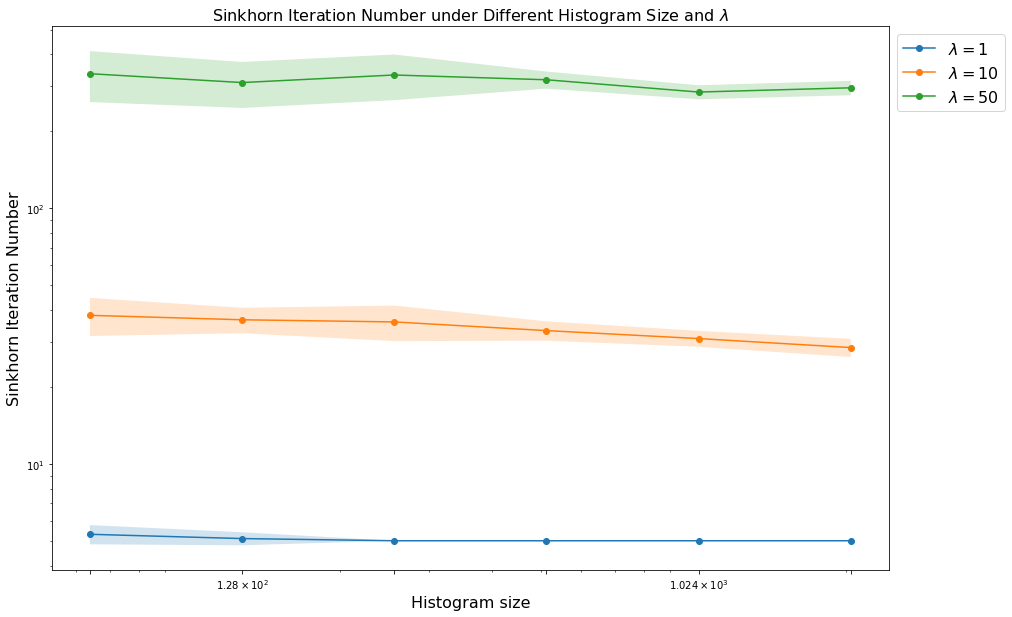

In [75]:
plt.figure(figsize = (15, 10))
plt.plot(size, mean_iter_1, label = "$\lambda = 1$", marker = 'o')
plt.fill_between(size, mean_iter_1 - std_iter_1, mean_iter_1 + std_iter_1, alpha = 0.2)
plt.plot(size, mean_iter_10, label = "$\lambda = 10$", marker = 'o')
plt.fill_between(size, mean_iter_10 - std_iter_10, mean_iter_10 + std_iter_10, alpha = 0.2)
plt.plot(size, mean_iter_50, label = "$\lambda = 50$", marker = 'o')
plt.fill_between(size, mean_iter_50 - std_iter_50, mean_iter_50 + std_iter_50, alpha = 0.2)
plt.yscale('log')
plt.xscale('log')
plt.xticks(ticks = size)
plt.xlabel("Histogram size", fontsize = 16)
plt.ylabel("Sinkhorn Iteration Number", fontsize = 16)
plt.title("Sinkhorn Iteration Number under Different Histogram Size and $\lambda$", fontsize = 16)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 16)
pass

### 4.2 Applications to real data sets

We've tested on MNIST data set in comparison with EMD. According to the requirement, we also find one other real-world data set not in the original paper and test it. Because optimal transport distances are computed for theoretical probability measures, it's hard to find real data sets which can directly use this method and describe the result. Therefore, we decide to use another image dataset, distances between image matrix can be interpreted as the difference between images. The image data we choose is [CalTech 101 Silhouettes Data Set](https://people.cs.umass.edu/~marlin/data.shtml). According to the description of this data, each image in the CalTech 101 data set includes a high-quality polygon outline of the primary object in the scene. The outline is rendered as a filled, black polygon on a white background. Many object classes exhibit silhouettes that have distinctive class-specific features.

(Figure)

In [ ]:
silhouettes = scipy.io.loadmat('data/silhouettes.mat')
img_mat = silhouettes.get('X')

# Conclusion

Overall, the Sinkhorn algorithm provides a good approximation to the exact optimal transport distance while maintain relatively low computational cost. As shown in the experiments, with increasing regularization parameter $\lambda$, the bias introduced by entropy regularization shrinks to a small scale quickly. However, we have to address that it is not always benificial to use a large $\lambda$, since the tests also showed that large regularization parameter $\lambda$ will induce a much larger of interation number required, thus imposing a heavier computational burden. The best practice would be choose the smallest $\lambda$ that can produce results satisfying the accuracy requirement based on the actual application scenario. 

On the other hand, the Sinkhorn algorithm also exposed its issues, and the most significant problem is the numerical instability. Even we have log-domain Sinkhorn to resolve it, there is still a price to pay. As discussed previously, the log-domain Sinkhorn lose the simple matrix-vector operation structure, thus can not be easily parallelized. Overall, the Sinkhorn and log-domain Sinkhorn are two algorithms each with advantages and disadvantages, which require us to apply the appropriate algorithm based on the actual scenario. 

Optimal transport distance can be applied in clustering problems. Given a dataset, we can use Sinkhorn algorithm to approximate the optimal transport distance, which quantifies the difference between observations, and apply clustering to find out observations with similar features. For image processing, we can use the same workflow to find out similar images. 

The improvements to the Sinkhorn algorithm focuses on its two main issues: bias and numerical instability. Since the Sinkhorn algorithm was proposed in 2013 by [1], the field of optimal transport has drawn the attention of a plethora of researchers, and many improvements based on the Sinkhorn algorithm are proposed. For example, the method "$\epsilon$ scaling" is proposed by [4] to resolve the numerical instability issue while maintain the structure of the original algorithm. Moreover, a debiased Sinkhorn algorithm was proposed in [6], and returned the metric property to the Sinkhorn distance. 

# Reference

[1]
M. Cuturi. 
Sinkhorn distances: Lightspeed computation of optimal transport.
In C. J. C. Burges, L. Bottou, M. Welling, Z. Ghahramani, and K. Q. Weinberger, editors, Advances in Neural Information Processing Systems 26, pages 2292–2300.
Curran Associates, Inc., 2013.

[2]
Pele, O. and Werman, M. 
Fast and robust earth mover’s distances. 
In ICCV’09., (2009). 

[3]
Ramdas, A., Trillos, N. G., and Cuturi, M. 
On Wasserstein two-sample testing and related families of nonparametric tests.
Entropy, 19(2). 2017. 

[4]
L. Chizat, G. Peyr\'e, B. Schmitzer, and F.-X. Vialard, 
Scaling algorithms for unbalanced optimal transport problems, 
Math. Comp., 87 (2018), pp. 2563–2609, 
https://doi.org/10.1090/mcom/3303.

[5]
M. Cuturi., G. Peyr\'e, 
Computational Optimal Transport. 
arXiv:1803.00567 [stat.ML]


[6]
H. Janati, M. Cuturi, and A. Gramfort, 
Debiased Sinkhorn Barycenters. 
arXiv:2006.02575v1 [stat.ML], 
Jun, 2020